In [1]:
!pip uninstall -y numpy scipy
!pip install numpy --upgrade
!pip install scipy --upgrade
!pip install gensim


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 46.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.6.5 requires scipy>=1.11.0, which is not installed.
jaxlib 0.5.1 requires scipy>=1.11.1, which is not installed.
jax 0.5.2 requires scipy>=1.11.1, which is not installed.
mizani 0.13.5 requires scipy>=1.8.0, which is not installed.
cuml-cu12 25.2.1 requires scipy>=1.8.0, which is not installed.
mlxtend 0.23.4 requires scipy>=1.2.1, which is not installed.
arviz 0.21.0 requires scipy>=1.9.0, which is not installed.
lightgbm 4.5.0 requires s

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import re
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk
from gensim.models import Word2Vec
from tensorflow.keras.models import load_model

In [2]:
# Загрузка данных
train = pd.read_csv('/content/drive/MyDrive/hw2/train.csv')
test = pd.read_csv('/content/drive/MyDrive/hw2/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/hw2/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (29568, 3)
Test shape: (7392, 2)


In [3]:
train

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


<ipython-input-4-c8f0ed6fd50c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Всего классов: 20
Общее количество размеченных примеров: 312471
Среднее количество меток на текст: 10.57

Топ-5 самых частых классов:
label_19    24300
label_18    23523
label_9     23344
label_13    23071
label_14    22997
dtype: int64

Топ-5 самых редких классов:
label_20    5765
label_4     1776
label_3     1490
label_7      206
label_6       99
dtype: int64


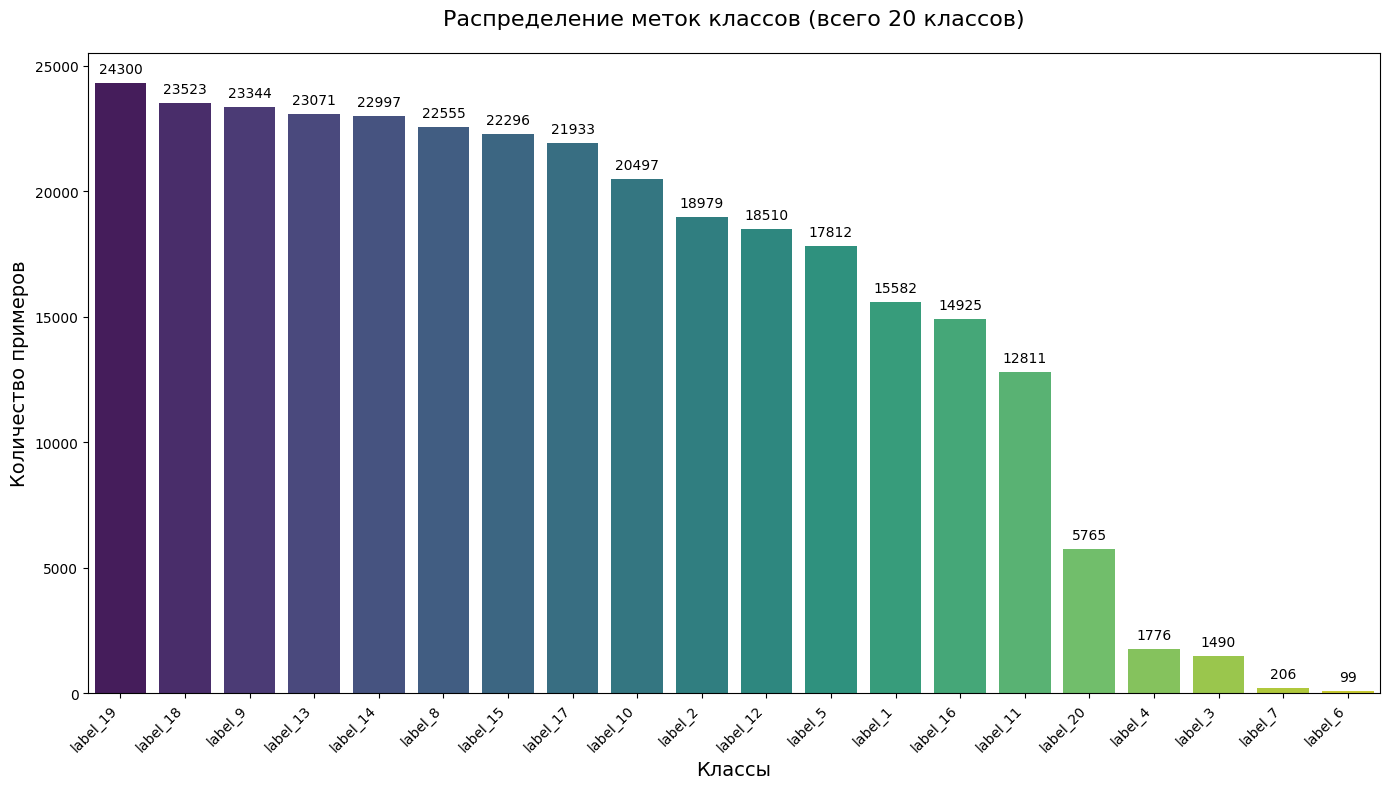

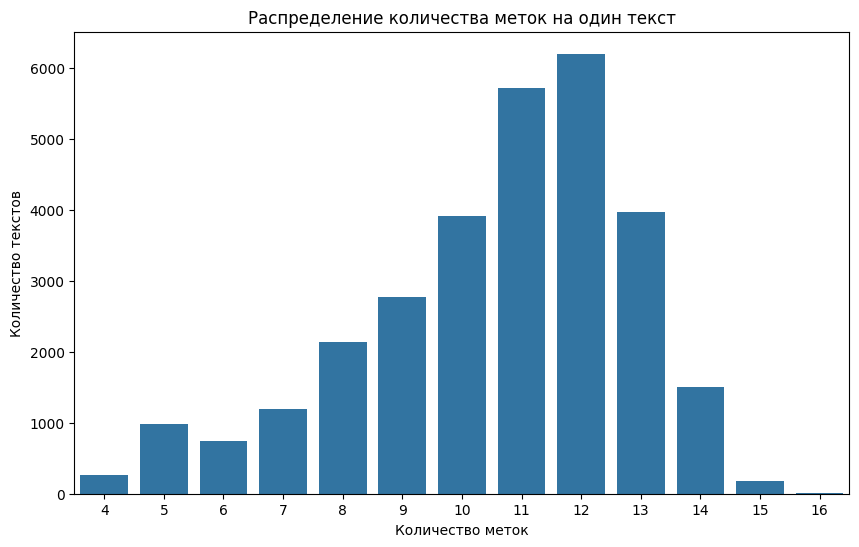

In [4]:
# Преобразуем строку меток в числовой массив
train['labels_list'] = train['labels'].apply(lambda x: list(map(int, x.split())))

# Количество классов (берем длину первого вектора меток)
num_classes = len(train['labels_list'].iloc[0])

# Создаем DataFrame с разбитыми метками
labels_df = pd.DataFrame(
    train['labels_list'].tolist(),
    columns=[f'label_{i+1}' for i in range(num_classes)]
)

# Распределение классов
class_distribution = labels_df.sum().sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x=class_distribution.index,
    y=class_distribution.values,
    palette="viridis"
)

# Добавляем значения на столбцы
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points'
    )

# Настройки отображения
plt.title(f"Распределение меток классов (всего {num_classes} классов)", fontsize=16, pad=20)
plt.xlabel("Классы", fontsize=14)
plt.ylabel("Количество примеров", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Дополнительная статистика
print(f"Всего классов: {num_classes}")
print(f"Общее количество размеченных примеров: {class_distribution.sum()}")
print(f"Среднее количество меток на текст: {labels_df.sum(axis=1).mean():.2f}")

# Топ классов
print("\nТоп-5 самых частых классов:")
print(class_distribution.head())
print("\nТоп-5 самых редких классов:")
print(class_distribution.tail())

# Распределение количества меток на текст
plt.figure(figsize=(10, 6))
labels_per_text = labels_df.sum(axis=1)
sns.countplot(x=labels_per_text)
plt.title("Распределение количества меток на один текст")
plt.xlabel("Количество меток")
plt.ylabel("Количество текстов")
plt.show()

<Axes: >

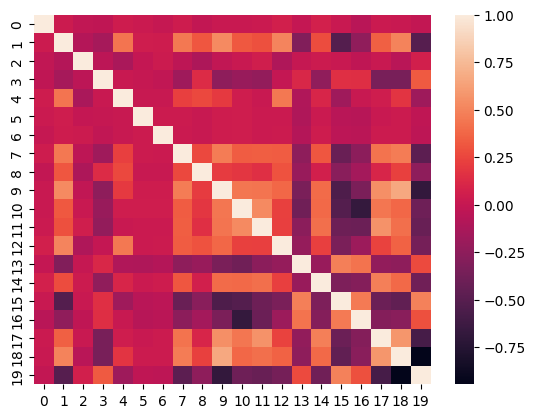

In [5]:
sns.heatmap(pd.DataFrame(train['labels_list'].tolist()).corr())

In [6]:
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

# Скачиваем стоп-слова, если не скачаны
nltk.download('stopwords')

# Инициализация
stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words("russian"))

# Стемминг
def simple_lemmatize(word):
    return stemmer.stem(word)

# Очистка для TF-IDF
def clean_tfidf(text):
    text = re.sub(r'<[^>]+>', '', text.lower())                  # HTML
    text = re.sub(r'https?://\S+', '[URL]', text)               # Ссылки
    text = re.sub(r'[\U0001F600-\U0001F64F]', '[EMOJI]', text)  # Эмодзи
    text = re.sub(r'[^а-яёa-z\s]', ' ', text)                   # Только буквы
    text = re.sub(r'\s+', ' ', text).strip()                    # Лишние пробелы

    words = [simple_lemmatize(word) for word in text.split()
             if word not in stop_words and len(word) > 2]

    return ' '.join(words)

# Очистка для Word2Vec
def clean_w2v(text):
    text = re.sub(r'<[^>]+>', '', text.lower())
    text = re.sub(r'https?://\S+', '[URL]', text)
    text = re.sub(r'[^\w\s\'-]', ' ', text)  # Сохраняем апострофы и дефисы
    return ' '.join([simple_lemmatize(w) for w in text.split()])

# Очистка для CNN/RNN
def clean_cnn(text):
    text = re.sub(r'<[^>]+>', '', text.lower())
    text = re.sub(r'https?://\S+', '[URL]', text)
    return re.sub(r'\s+', ' ', text).strip()

# Очистка для BERT
def clean_bert(text):
    return text.strip()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Преобразование меток в numpy array
y = np.array(train['labels_list'].tolist())

# Разделение данных (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    train['text'], y,
    test_size=0.2,
    random_state=42,
    stratify=y.sum(axis=1)  # Стратификация по количеству меток
)

In [ ]:
# --- Векторизация ---
tfidf = TfidfVectorizer(
    max_features=20000,
    preprocessor=clean_tfidf,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
# --- Модель ---
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_tfidf.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y.shape[1], activation='sigmoid')  # для многоклассовой бинарной классификации
])

# --- Метрики и лоссы ---
# Можно switchить лоссы/метрики:
LOSS = 'binary_crossentropy'
METRICS = [tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

model.compile(optimizer='adam', loss=LOSS, metrics=METRICS)

# --- Callbacks ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model_tfidf.h5', monitor='val_auc', save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=2, mode='max', verbose=1)
]

# --- Вормап (классовые веса)

# --- Обучение ---
history = model.fit(
    X_train_tfidf.toarray(), y_train,
    validation_data=(X_val_tfidf.toarray(), y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    # class_weight=class_weights
)

# --- Графики ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('AUC over epochs')
plt.legend()

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - auc: 0.8925 - loss: 0.3983 - precision: 0.7902 - recall: 0.8919

370/370 ━━━━━━━━━━━━━━━━━━━━ 99s 262ms/step - auc: 0.8926 - loss: 0.3980 - precision: 0.7903 - recall: 0.8920 - val_auc: 0.9708 - val_loss: 0.2190 - val_precision: 0.9050 - val_recall: 0.9175 - learning_rate: 0.0010
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - auc: 0.9775 - loss: 0.1928 - precision: 0.9172 - recall: 0.9295

370/370 ━━━━━━━━━━━━━━━━━━━━ 134s 242ms/step - auc: 0.9775 - loss: 0.1928 - precision: 0.9172 - recall: 0.9295 - val_auc: 0.9761 - val_loss: 0.1968 - val_precision: 0.9165 - val_recall: 0.9236 - learning_rate: 0.0010
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - auc: 0.9875 - loss: 0.1445 - precision: 0.9420 - recall: 0.9484

370/370 ━━━━━━━━━━━━━━━━━━━━ 143s 244ms/step - auc: 0.9875 - loss: 0.1445 - precision: 0.9420 - recall: 0.9484 - val_auc: 0.9771 - val_loss: 0.1951 - val_precision: 0.9220 - val_recall: 0.9245 - learning_rate: 0.0010
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - auc: 0.9925 - loss: 0.1122 - precision: 0.9583 - recall: 0.9602

370/370 ━━━━━━━━━━━━━━━━━━━━ 139s 237ms/step - auc: 0.9925 - loss: 0.1122 - precision: 0.9583 - recall: 0.9602 - val_auc: 0.9772 - val_loss: 0.1992 - val_precision: 0.9215 - val_recall: 0.9275 - learning_rate: 0.0010
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 151s 263ms/step - auc: 0.9948 - loss: 0.0926 - precision: 0.9665 - recall: 0.9671 - val_auc: 0.9761 - val_loss: 0.2111 - val_precision: 0.9219 - val_recall: 0.9274 - learning_rate: 0.0010
Epoch 6/20
126/370 ━━━━━━━━━━━━━━━━━━━━ 1:01 251ms/step - auc: 0.9965 - loss: 0.0759 - precision: 0.9740 - recall: 0.9742

In [ ]:
y_val_pred_prob = model.predict(X_val_tfidf.toarray())
y_val_pred = (y_val_pred_prob > 0.5).astype(int)
f1_macro_val = f1_score(y_val, y_val_pred, average='macro')
print(f'Final val F1 macro: {f1_macro_val:.4f}')



In [ ]:
#Преобразование текста в список слов
X_train_clean = [clean_w2v(text).split() for text in X_train]
X_val_clean = [clean_w2v(text).split() for text in X_val]

#Обучаем Word2Vec
w2v_model = Word2Vec(sentences=X_train_clean, vector_size=100, window=5, min_count=2, workers=4, epochs=10)

# --- Функция для усреднения эмбеддингов слов в тексте ---
def texts_to_embeddings(texts, model, vector_size=100):
    embeddings = []
    for tokens in texts:
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            emb = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            emb = np.zeros(vector_size)
        embeddings.append(emb)
    return np.array(embeddings)

X_train_emb = texts_to_embeddings(X_train_clean, w2v_model)
X_val_emb = texts_to_embeddings(X_val_clean, w2v_model)

# --- Классовые веса

# --- Параметры ---
LOSS = 'binary_crossentropy'
METRICS = [tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

# --- Модель ---
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_emb.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')  # или softmax для multi-class
])

model.compile(optimizer='adam', loss=LOSS, metrics=METRICS)

# --- Callbacks ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model_w2v.h5', monitor='val_auc', save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=2, mode='max', verbose=1)
]

# --- Обучение ---
history = model.fit(
    X_train_emb, y_train,
    validation_data=(X_val_emb, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

# --- Графики ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('AUC over epochs')
plt.legend()

plt.show()

In [ ]:
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt


#Подготовка данных
X_train_clean = [clean_cnn(text) for text in X_train]
X_val_clean = [clean_cnn(text) for text in X_val]

# Токенизация
max_words = 20000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_val_seq = tokenizer.texts_to_sequences(X_val_clean)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

#Модель CNN
def create_cnn_model(max_words, embedding_dim=128, max_len=200, num_classes=None):
    inputs = tf.keras.Input(shape=(max_len,))
    x = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(inputs)
    x = tf.keras.layers.Conv1D(128, 5, activation='relu')(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)  # для multi-label бинарной классификации

    model = tf.keras.Model(inputs, outputs)
    return model

num_classes = y_train.shape[1] if len(y_train.shape) > 1 else 1
model_cnn = create_cnn_model(max_words=max_words, num_classes=num_classes)

# --- Свитч лоссов и метрик ---
LOSS = 'binary_crossentropy'
METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

model_cnn.compile(optimizer='adam', loss=LOSS, metrics=METRICS)

# Колбэки
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model_cnn.h5', monitor='val_auc', save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=2, mode='max', verbose=1)
]

#Обучение
history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

#Графики
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='train loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.title('Loss over epochs (CNN)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['auc'], label='train AUC')
plt.plot(history_cnn.history['val_auc'], label='val AUC')
plt.title('AUC over epochs (CNN)')
plt.legend()

plt.show()


In [ ]:
def create_rnn_model(max_words, embedding_dim=128, max_len=200, num_classes=None):
    inputs = tf.keras.Input(shape=(max_len,))
    x = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model_rnn = create_rnn_model(max_words=max_words, num_classes=num_classes)

model_rnn.compile(optimizer='adam', loss=LOSS, metrics=METRICS)

callbacks_rnn = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model_rnn.h5', monitor='val_auc', save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=2, mode='max', verbose=1)
]

history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks_rnn,

)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='train loss')
plt.plot(history_rnn.history['val_loss'], label='val loss')
plt.title('Loss over epochs (RNN)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['auc'], label='train AUC')
plt.plot(history_rnn.history['val_auc'], label='val AUC')
plt.title('AUC over epochs (RNN)')
plt.legend()

plt.show()


In [ ]:
def evaluate_f1_macro(model, X_val, y_val, threshold=0.5):
    # Получаем предсказания вероятностей
    y_pred_prob = model.predict(X_val)

    # Преобразуем вероятности в бинарные метки
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Вычисляем F1-макро
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"F1-score (macro): {f1:.4f}")
    return f1


In [ ]:
best_cnn = load_model('best_model_cnn.h5')
evaluate_f1_macro(best_cnn, X_val_pad, y_val)


In [ ]:
best_w2v = load_model('best_model_w2v.h5')
evaluate_f1_macro(best_w2v, X_val_emb, y_val)


In [ ]:
best_tfidf = load_model('best_model_tfidf.h5')
evaluate_f1_macro(best_tfidf, X_val_tfidf.toarray(), y_val)


In [ ]:
best_rnn = load_model('best_model_rnn.h5')
evaluate_f1_macro(best_rnn, X_val_pad, y_val)


In [ ]:
import pandas as pd
import numpy as np

# y_test_pred — numpy array размером (num_samples, 20), значения 0 или 1 (или float, тогда надо округлить)
# sample_submission — прочитанный dataframe с колонками ['id', 'labels']

# Преобразуем предсказания в строку с пробелами
y_test_str = [' '.join(map(str, row.astype(int))) for row in y_test_pred]

# Запишем в колонку 'labels' сабмит датафрейма
sample_submission['labels'] = y_test_str

# Сохраним файл сабмита
sample_submission.to_csv('submission_tfidf.csv', index=False)

print("Submission saved!")


In [ ]:
import numpy as np
import random

def add_noise_to_text(text, noise_level=0.1):
    words = text.split()
    n_noise = max(1, int(len(words) * noise_level))
    for _ in range(n_noise):
        idx = random.randint(0, len(words)-1)
        # Заменим слово случайным словом из словаря TF-IDF
        random_word = random.choice(tfidf.get_feature_names_out())
        words[idx] = random_word
    return ' '.join(words)

# Получаем распределение по сумме меток
label_sums = y_train.sum(axis=1)

# Инициализируем новые данные
new_texts = []
new_labels = []

# Сэмплируем 1000 примеров с похожим распределением сумм меток
for _ in range(1000):
    # Случайно выбираем пример, учитывая распределение по меткам
    chosen_idx = np.random.choice(len(X_train), p=label_sums/label_sums.sum())
    original_text = X_train.iloc[chosen_idx]
    original_label = y_train[chosen_idx]

    # Добавляем шум к тексту
    noisy_text = add_noise_to_text(original_text, noise_level=0.1)

    new_texts.append(noisy_text)
    new_labels.append(original_label)

# Объединяем с исходными данными
X_train_aug = pd.concat([X_train, pd.Series(new_texts)], ignore_index=True)
y_train_aug = np.vstack([y_train, np.array(new_labels)])

print(f"Original train size: {len(X_train)}, after augmentation: {len(X_train_aug)}")

# Перевекторизуем (TF-IDF)
X_train_tfidf_aug = tfidf.fit_transform(X_train_aug)
X_val_tfidf = tfidf.transform(X_val)  # валид остаётся как есть

# Обучаем модель заново на расширенных данных
model_aug = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_tfidf_aug.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y.shape[1], activation='sigmoid')
])

model_aug.compile(optimizer='adam', loss=LOSS, metrics=METRICS)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model_tfidf_aug.h5', monitor='val_auc', save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=2, mode='max', verbose=1)
]

history_aug = model_aug.fit(
    X_train_tfidf_aug.toarray(), y_train_aug,
    validation_data=(X_val_tfidf.toarray(), y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
)

# Загрузим лучшую модель
best_model_aug = tf.keras.models.load_model('best_model_tfidf_aug.h5')

# Оценим F1 macro (используйте свою функцию evaluate_f1_macro)
evaluate_f1_macro(best_model_aug, X_val_tfidf.toarray(), y_val)
